### Electron Microscopy analysis of Tadpole tectum nuclei

This code will determine the percent chromatin for nuclei within an EM image

### To run this code you will need: 
1. A line drawn around the nuclei (done in ImageJ) and saved as Cell**_NPerimeter.txt
2. Organization such that there is a "Cell Files" folder which has folders for each condition in it. Then condition folders will have a folder for each cell labeled "Cell**", and within these cell folders you will have your images (.TIF files) and _NPerimeter.txt file. 

In [1]:
#Import packages for use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import seaborn as sns
from PIL import Image, ImageDraw
import cv2
sns.set()
sns.set_style('white')

In [2]:
#Functions needed (by ARA)

def to_gray(image, color_space="RGB", cv2_color=None):
    """
    Converts the inputted image to gray scale.

    This function should serve as a wrapper for cv2.cvtColor with basic input
    checking. Its main use is to convert color images to gray scale but it can
    be used as an alias to cv2.cvtColor if a color conversion code is passed
    into cv2_color

    Parameters
    ----------
    image : np.ndarray
        Image to convert to grayscale.

    color_space : str, optional
        Color space of the image. Valid entries are 'RGB', 'BGR'.

    cv2_color : cv2.ColorConversionCodes
        OpenCV color conversion code. Bypasses image array checks if used.

    Returns
    -------
    image_gray : np.ndarray
        The image converted to gray scale (ie len(image.shape) is 2)

    Raises
    ------
    InputError
        If input is not an image or color_space is invalid.
    """
    # Check if an OpenCV color conversion was entered
    if cv2_color is not None:
        color = cv2_color
        
    else:
        # Check we are getting an image
        if len(image.shape) < 2:
            raise InputError("Got array that is not an image. Shape is {0}."
                             "".format(image.shape))

        # Check that it isn't already grayscale
        if len(image.shape) < 3:
            logger.warning("Got image that is already grayscale.")
            return image

        # Check for the color space
        if color_space.upper() == "RGB":
            color = cv2.COLOR_RGB2GRAY
        elif color_space.upper() == "BGR":
            color = cv2.COLOR_BGR2GRAY
        else:
            raise InputError("Invalid color_space entry. Got '{0}'".format(
                color_space))

    # Do the conversion
    return cv2.cvtColor(image, color)

def to_uint8(image, mode="scale"):
    """
    *Correctly* converts an image to uint8 type.
    
    Running 'image.astype(np.uint8)' on its own applies a mod(256) to handle
    values over 256. The correct way is to either clip (implemented here) or
    normalize to the the max and min possible values of the array. Below are the
    available conversion modes:

    clip
        Truncates the  image at 0 and 255, then returns the resulting array.

    norm
        Normalizes the image so that the maximum value of the input array is set
        to 255 and the minimum value is 0.
    
    scale
        Scales the image so that the maximum and minimum values of the resulting
        array corresponds to the maximum and minimum possible values of the
        input array.

    Parameters
    ----------
    image : np.ndarray
        Image to be converted to uint8.

    mode : str, optional 
        Conversion mode to use. See conversion modes for more details.

    Returns
    -------
    np.ndarray
        Image that is a np.ndarray with dtype uint8.
    """
    # The main hurdle with performing the clipping is making sure we don't
    # create values that exceed the buffer size of the inputted dtype. For
    # example, for float32 the maximum value is 65504.0 and the min value is
    # 65504.0. If you try to find the range using a float32 by doing 65504.0 -
    # (-65504.0) you will get Inf.
    
    # Make sure the image is a numpy array
    if not isinstance(image, np.ndarray):
        image_array = np.array(image)
    else:
        image_array = np.copy(image)
        
    # Clip or normalize the image
    if mode.lower() == "clip":
        output = np.clip(image_array, 0, 255)

    # Normalize to max and min values of the array
    elif mode.lower() == "norm":
        range_pixels = image_array.max() - image_array.min() or 1        
        output = 255 * (image_array - image_array.min()) / range_pixels
        
    # Scale according to the max and min possible values of the array
    elif mode.lower() == "scale":
        try:
            # Grab array info for int types
            type_min = np.iinfo(image_array.dtype).min
            type_max = np.iinfo(image_array.dtype).max
        except ValueError:
            # Grab array info for float types
            type_min = np.finfo(image_array.dtype).min
            type_max = np.finfo(image_array.dtype).max
        # Use half the range to guarantee we can fit the range in the variable
        range_half = type_max/2 - type_min/2
        output = ((image_array/2 - type_min/2)/range_half) * 255

    # Handle invalid inputs
    else:
        raise InputError("Invalid conversion mode inputted. Valid modes are " 
                         "'clip' and 'norm.'")

    # Warn the user if the preprocessing resulted in a zeroed array
    if not output.any() and image_array.any():
        logger.warning("to_uint8 resulted in a fully zeroed array from "
                       "non-zero input.")

    # Return casting as uint8
    return output.astype(np.uint8)

def uint_resize_gauss(image, mode='scale', fx=1.0, fy=1.0, kernel=(11,11), 
                      sigma=0):
    """
    Preprocess the image by converting to uint8, resizing and running a 
    gaussian blur.
    
    Parameters
    ----------
    image : np.ndarray
        The image to be preprocessed.

    mode : str, optional 
        Conversion mode that either clips the image or normalizes to the range
        of the original image type.

    fx : float, optional
        Percent to resize the image by in x.

    fy : float, optional
        Percent to resize the image by in y.

    kernel : tuple, optional
        Kernel to use when running the gaussian filter.

    Returns
    -------
    np.ndarray 
        Image of type uint8 that has been resized and blurred.
    """
    image_uint = to_uint8(image, mode=mode)
    image_resized = cv2.resize(image_uint, (0,0), fx=fx, fy=fy)
    image_gblur = cv2.GaussianBlur(image_resized, kernel, sigma)
    return image_gblur

def threshold_image(image, binary=True, mode="top", factor=1, **kwargs):
    """
    Thresholds the image, creating a binary image.

    The thresholding can be done using one of the following modes:

    mean
        Set the threshold line to be image.mean + image.std*factor.

    top
        Sets the threshold line to be image.max - image.std*factor, leaving just
        the highest intensity pixels.

    bottom
        Sets the threshold line to be image.min + image.std*factor, removing
        just the lowest intensity pixels

    adaptive
        Sets threshold line according to a weighed sum of neughborhood values
        using a gaussian window. See 'Adaptive Thresholding' in the following
        link for more details.
        http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html

    otsu
        Sets the threshold to be between the histogram peaks of a bimodal image.
        See "Otsu's Binarization" in the following for more details.
        http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html

    Parameters
    ----------
    image : np.ndarray
        The image to threshold.

    binary : bool, optional
        Use binary thresholding or to_zero thresholding.

    mode : str, optional
        Thresholding mode to use. See docstring for more information.

    factor : int, optional
        Number of times to multiply the std by before adding to the mean for
        thresholding.    
        
    Returns
    -------
    th : np.ndarray
        Image that has been thresholded.
    """
    valid_modes = set(['mean', 'top', 'bottom', 'adaptive', 'otsu'])
    if binary:
        th_type = cv2.THRESH_BINARY
    else:
        th_type = cv2.THRESH_TOZERO

    # Find the right mode
    if mode.lower() not in valid_modes:
        raise InputError("Invalid mode passed for thresholding.")
    elif mode.lower() == 'mean':
        _, th = cv2.threshold(image, image.mean() + image.std()*factor, 
                              255,
                              th_type)        
    elif mode.lower() == 'top':
        _, th = cv2.threshold(image, image.max() - image.std()*factor, 
                              255,
                              th_type)
    elif mode.lower() == 'bottom':
        _, th = cv2.threshold(image, image.min() + image.std()*factor, 
                              255,
                              th_type)
    elif mode.lower() == "adaptive":
        blockSize = kwargs.pop("BlockSize", 11)
        C = kwargs.pop("C", 2)        
        th = cv2.adaptiveThreshold(image, 
                                   255, 
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   th_type, 
                                   blockSize, 
                                   C)
    elif mode.lower() == "otsu":
        _, th = cv2.threshold(image, 0, 255, th_type+cv2.THRESH_OTSU)

    return th



def get_opening(image, n_erode=1, n_dilate=1, kernel=(5,5)):
    """
    Performs the specified number of erosions, followed by the specified number
    of dilations to get the opening of the image.

    Parameters
    ----------
    image : np.ndarray
        The image to perform the opening on. Must be a binary image

    n_erode : int, optional
        The number of times to perform an erosion on the image.

    n_dilate : int, optional
        The number of times to perform a dilation on the image.

    kernel : tuple, optional
        The kernel size to use when eroding and dilating.

    Returns
    -------
    image_opened : np.ndarray
        Image that has had n_erode erosions followed by n_dilate dilations.

    Raises
    ------
    InputError
        When image passed is not a binary image
    """
    # Check that image is binary
    if len(np.unique(image)) > 2:
        raise InputError("Binary image is required for morphological "
                         "transformations.")
    kernel = np.ones(kernel, dtype=np.uint8)    
    image_eroded = cv2.erode(image, kernel, iterations=n_erode)
    image_opened = cv2.dilate(image_eroded, kernel, iterations=n_dilate)
    return image_opened

def get_closing(image, n_erode=1, n_dilate=1, kernel=(5,5)):
    """
    Performs the specified number of dilations, followed by the specified number
    of erosions to get the closing of the image.

    Parameters
    ----------
    image : np.ndarray
        The image to perform the closing on.

    n_erode : int, optional
        The number of times to perform an erosion on the image.

    n_dilate : int, optional
        The number of times to perform a dilation on the image.

    kernel : tuple, optional
        The kernel size to use when eroding and dilating.

    Returns
    -------
    image_opened : np.ndarray
        Image that has had n_dilate dilations followed by n_erode erosions.

    Raises
    ------
    InputError
        When image passed is not a binary image
    """
    if len(np.unique(image)) > 2:
        raise InputError("Binary image is required for morphological "
                         "transformations.")
    kernel = np.ones(kernel, dtype=np.uint8)
    image_dilated = cv2.dilate(image, kernel, iterations=n_dilate)
    image_closed = cv2.erode(image_dilated, kernel, iterations=n_erode)
    return image_closed

In [4]:
def line_array(cell_path):
#Code to turn NPerimeter line into X,Y coordinates
    img_conversion = 293 

    #Define our path as anything in folders with an .txt in it    
    assert cell_path.exists()

    NP_txt = cell_path / Path(cell_path.name + '_NPerimeter.txt')
    print(NP_txt)
    assert NP_txt.exists()

    #Read the X,Y coordinates from the NP.txt file and convert to pixels
    df = np.round(pd.read_table(str(NP_txt), header=None)*img_conversion, decimals=0)
    df_diff = df.diff()
    
    #Finding Euclidean distance
    df_ed = np.sqrt(df_diff.iloc[:,0]**2 +df_diff.iloc[:,1]**2) 
        #This code will only give you some pixel X,Y coordinates, not everything on that line

    
    #Get the distances of all X,Y coordinates on that line:
    #If the distance between 2 pixel points is more than 1, fill in the blanks by 1 to make a continuous line
    x_fin, y_fin = [], [] 
    for i in range(len(df)): 
        x, y = df.iloc[i,:]
        x_fin.append(x)
        y_fin.append(y)
    
    #Create an array for all X,Y coordinates along your NP line
    L = np.array([x_fin,y_fin]).T    

    #Self check: If you want to see all of your X,Y values of your line now
    Ltabletest = {'X values':x_fin, 'Y values':y_fin}
    Ltable_pd = pd.DataFrame(Ltabletest)
   
    
    return L,  Ltable_pd.head()

In [7]:
#Threhsolding: Part 1- Open image
cell_path1 = Path('C:/Users/audre/Documents/GitHub/Aizenman-Lab/Cell20.tif')
cell_path2 = Path('C:/Users/audre/Documents/GitHub/Aizenman-Lab/Cell29.tif')
cell_path3 = Path('C:/Users/audre/Documents/GitHub/Aizenman-Lab/Cell103.tif')
img1 = Image.open(cell_path1)
img2 = Image.open(cell_path2)
img3 = Image.open(cell_path3)

nuc_image_np1 = to_uint8(np.array(img1))
nuc_image_np2 = to_uint8(np.array(img2))
nuc_image_np3 = to_uint8(np.array(img3))

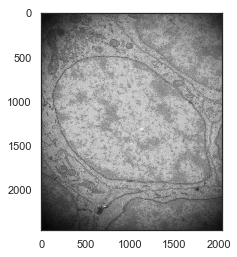

In [10]:
plt.imshow(nuc_image_np1, cmap='gray')

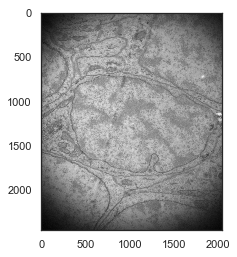

In [11]:
plt.imshow(nuc_image_np2, cmap='gray')

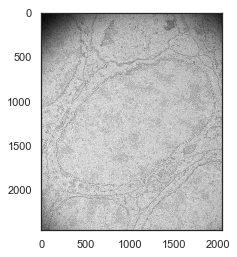

In [12]:
plt.imshow(nuc_image_np3, cmap='gray')

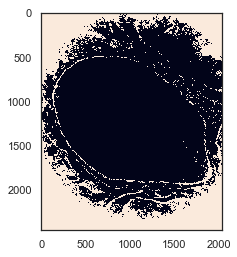

In [13]:
#Thresholding: Img1
nuc_thresh = np.invert(threshold_image(nuc_image_np1, mode='otsu'))
plt.imshow(nuc_thresh)

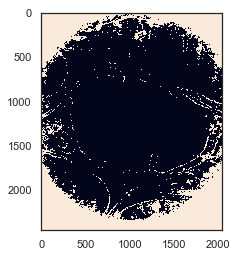

In [14]:
#Thresholding: Img2
nuc_thresh = np.invert(threshold_image(nuc_image_np2, mode='otsu'))
plt.imshow(nuc_thresh)

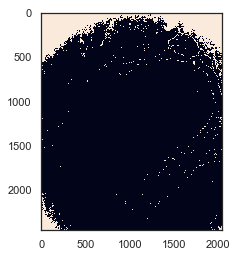

In [15]:
#Thresholding: Img3
nuc_thresh = np.invert(threshold_image(nuc_image_np3, mode='otsu'))
plt.imshow(nuc_thresh)

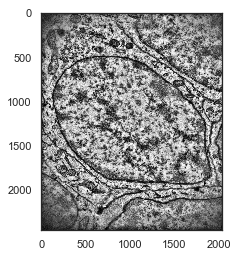

In [20]:
# Contrast enhancement, Img1    
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(21,21))
nuc_image_clahe1 = clahe.apply(nuc_image_np1)
plt.imshow(nuc_image_clahe1, cmap='gray')

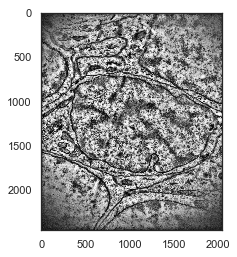

In [21]:
# Contrast enhancement, Img2   
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(21,21))
nuc_image_clahe2 = clahe.apply(nuc_image_np2)
plt.imshow(nuc_image_clahe2, cmap='gray')

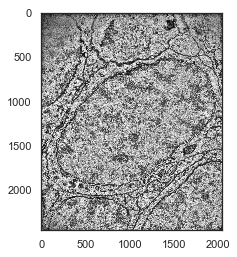

In [22]:
# Contrast enhancement, Img3  
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(21,21))
nuc_image_clahe3 = clahe.apply(nuc_image_np3)
plt.imshow(nuc_image_clahe3, cmap='gray')

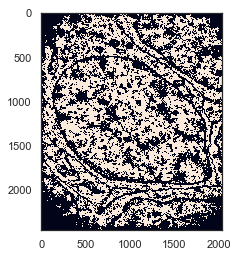

In [23]:
 # Otsu adaptive thresholding: Img1
nuc_clahe_thresh1 = threshold_image(nuc_image_clahe1, mode='otsu')
plt.imshow(nuc_clahe_thresh1)

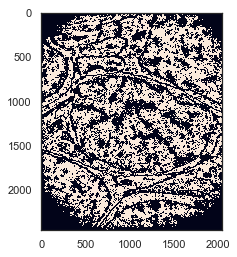

In [24]:
 # Otsu adaptive thresholding: Img2
nuc_clahe_thresh2 = threshold_image(nuc_image_clahe2, mode='otsu')
plt.imshow(nuc_clahe_thresh2)

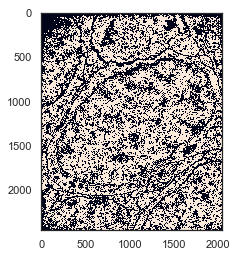

In [25]:
 # Otsu adaptive thresholding: Img3
nuc_clahe_thresh3 = threshold_image(nuc_image_clahe3, mode='otsu')
plt.imshow(nuc_clahe_thresh3)

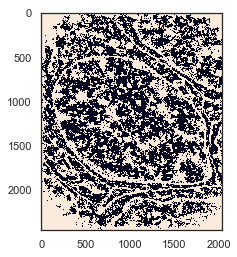

In [26]:
#Inversion: Img1
nuc_clahe_inv1 = np.invert(nuc_clahe_thresh1)
plt.imshow(nuc_clahe_inv1)

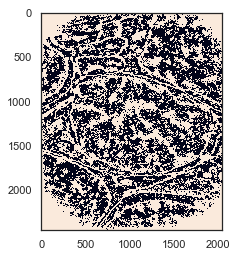

In [27]:
#Inversion: Img1
nuc_clahe_inv2 = np.invert(nuc_clahe_thresh2)
plt.imshow(nuc_clahe_inv2)

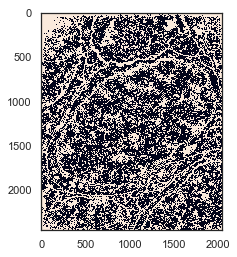

In [28]:
#Inversion: Img1
nuc_clahe_inv3 = np.invert(nuc_clahe_thresh3)
plt.imshow(nuc_clahe_inv3)